In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
pd.set_option('display.max_rows', 150)

In [4]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [5]:
acs = pd.read_csv('acs2_clean.csv', index_col = 0,
                   parse_dates=['Time']
                  )


In [57]:
acs.columns.to_list()

['zip_code',
 'commuting_population',
 'divorced_men',
 'driving_alone_population',
 'housing_units_built_1940_to_1949',
 'quintile_2_income_share',
 'housing_units_10_to_19_units_rented',
 'quintile_3_income_share',
 'married_women_spouse_absent',
 'female_80_to_84',
 'female_45_to_49',
 'female_75_to_79',
 'married_men',
 'motorcycle_population',
 'female_60_to_61',
 'male_20',
 'housing_units_10_to_19_units_owned',
 'male_21',
 'men_with_professional_degree',
 'housing_units_over_50_units_rented',
 'quintile_5_income_share',
 'housing_units_single_family_detached_rented',
 'housing_units_built_1950_to_1959',
 'women_with_professional_degree',
 'total_contract_rent',
 'bicycle_population',
 'male_30_to_34',
 'housing_units_other_type',
 'male_18_to_19',
 'average_household_size_renters',
 'other_commute_method_population',
 'male_50_to_54',
 'married_men_spouse_absent',
 'marital_status_population',
 'housing_units_3_to_4_units_owned',
 'quintile_4_upper_limit',
 'quintile_3_upper_li

In [6]:
zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



#### prepping for mapping 

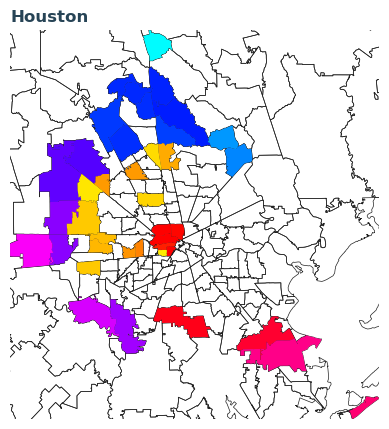

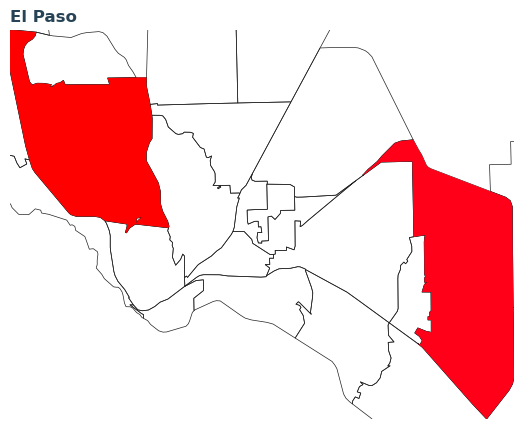

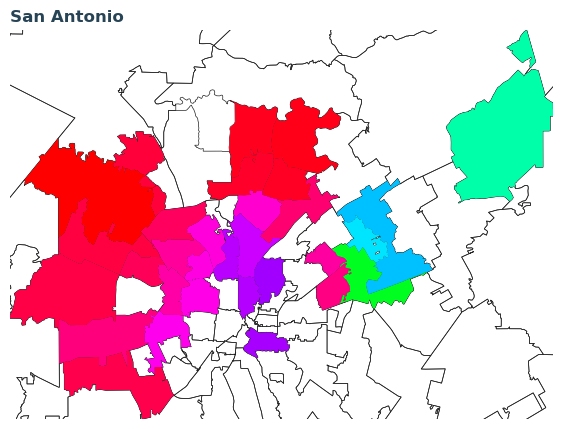

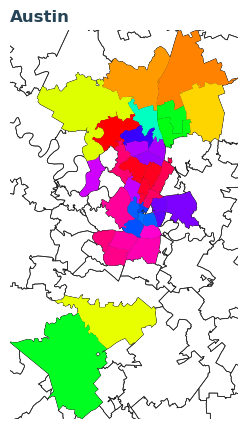

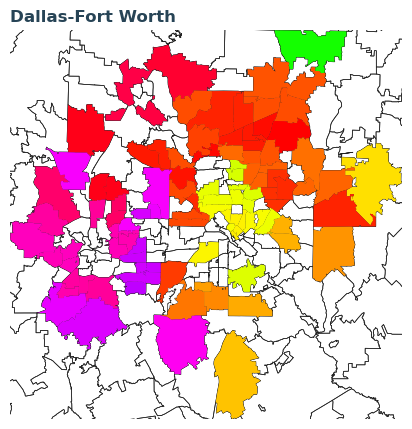

In [7]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = different_metros[metro].total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro)
    plt.show()

### now 12 month lag

In [8]:
# zri_shift 6-12 months
zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_cols = True
                                         )
zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift = zri_shift[['Time','zip_code','zori_ssa', 'zori_ssa_12_month_shift',
                       'zori_ssa_18_month_shift',
                       'zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12']]
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])



acs feature engineering

In [9]:
acs['renter_occupied_ratio'] = acs['renter_occupied_units']/acs['occupied_units']
# should make something to get a sense of
# gentrification by looking at the quartile income stuff

Adding a lag to acs so that i can put in a percent differnce from the year before and not just the actual values per zip

In [10]:
acs_shift, acs_shift_X_vals = helper.time_lag_merge(acs, acs, {
    12:list(acs.drop(columns = ['Time','zip_code']).columns),
},
                                          return_cols = True
                                         )

In [11]:
acs_shift = acs_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
acs_cols = list(acs.drop(columns=['Time', 'zip_code']).columns)
acs_cols_per = []
acs_new_cols = []
# acs_shift = acs_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
for acs_col in acs_cols:
    new_col_name = acs_col + '_per_diff_last_year'
#     acs_cols_per.append(new_col_name)
    new_col = ((acs_shift.loc[:,acs_col] - 
                                 acs_shift.loc[:,acs_col+'_12_month_shift'])/
                                acs_shift.loc[:,acs_col])
    new_col = pd.DataFrame({new_col_name:new_col})
    acs_new_cols.append(new_col)
    
acs_shift = pd.concat([acs_shift[['Time', 'zip_code']],
                       pd.concat(acs_new_cols,axis=1).dropna(axis='columns', 
                                                             thresh = 20000)],
                      axis=1)

In [12]:
zri_shift1, acs_X_vals = helper.time_lag_merge(zri_shift, acs_shift, {
    24: list(acs_shift.drop(columns = ['Time','zip_code']).columns)
},
                                          return_cols = True
                                         )

zri_shift = zri_shift1.dropna(axis='index',how = 'any').reset_index(drop = True)

In [13]:
zri_shift.shape

(12735, 140)

In [14]:
## future hayden figure out why there are infinities

In [15]:
zri_shift = zri_shift.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
zri_shift.shape 

(12070, 140)

In [16]:

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [64]:
X_vals = ['zori_ssa_12_month_shift',
#             'zori_ssa_18_month_shift', 
            'zori_ssa_1_diff_lag_12', 
          'zori_ssa_6_diff_lag_12', ### causes autocorrelation... but its worth it?
            'zori_ssa_12_diff_lag_12_per', ### causes autocorrelation... but its worth it?
                       ] + acs_X_vals
bad_X_vals = ['women_with_doctoral_degree_per_diff_last_year_24_month_shift',
              'female_40_to_44_per_diff_last_year_24_month_shift',
              'female_85_over_per_diff_last_year_24_month_shift',
              'housing_units_built_1950_to_1959_per_diff_last_year_24_month_shift',
              # quintile_5_income_share and quintile_5_mean_income are both there. 
              # removing just one.
              'quintile_5_income_share_per_diff_last_year_24_month_shift',
              'quintile_2_income_share_per_diff_last_year_24_month_shift',
              'quintile_3_income_share_per_diff_last_year_24_month_shift',
              'quintile_4_income_share_per_diff_last_year_24_month_shift',
              'quintile_1_income_share_per_diff_last_year_24_month_shift',
              'top_5_percent_income_share_per_diff_last_year_24_month_shift',
              
              'quintile_1_upper_limit_per_diff_last_year_24_month_shift',
            'quintile_2_upper_limit_per_diff_last_year_24_month_shift',
            'quintile_3_upper_limit_per_diff_last_year_24_month_shift',
            'quintile_4_upper_limit_per_diff_last_year_24_month_shift',
            'quintile_5_upper_limit_per_diff_last_year_24_month_shift',
              # the same as occupied_units
              'total_households_per_diff_last_year_24_month_shift',
              # the similiar to total_population_in_occupied_units
              'total_population_per_diff_last_year_24_month_shift',
              # occupied_units and created ratio will have this info
              'owner_occupied_units_per_diff_last_year_24_month_shift',
              'total_population_in_owner_occupied_units_per_diff_last_year_24_month_shift',
              'renter_occupied_units_per_diff_last_year_24_month_shift',
              'total_population_in_renter_occupied_units_per_diff_last_year_24_month_shift',
              'occupied_units_per_diff_last_year_24_month_shift',
              'total_household_income_per_diff_last_year_24_month_shift',
              
              'male_population_per_diff_last_year_24_month_shift',
              'marital_status_population_per_diff_last_year_24_month_shift',
              
              'total_contract_rent_per_diff_last_year_24_month_shift',
              
              'married_men_spouse_present_per_diff_last_year_24_month_shift',
              'married_women_per_diff_last_year_24_month_shift',
              
              'education_population_per_diff_last_year_24_month_shift',
              
              'total_gross_rent_per_diff_last_year_24_month_shift',
              'renter_occupied_ratio_per_diff_last_year_24_month_shift',
              
              'female_population_per_diff_last_year_24_month_shift',
              
              'driving_alone_population_per_diff_last_year_24_month_shift',
              'top_5_percent_mean_income_per_diff_last_year_24_month_shift',
              
              'married_men_per_diff_last_year_24_month_shift',
            'average_household_size_per_diff_last_year_24_month_shift',
            'quintile_5_mean_income_per_diff_last_year_24_month_shift',
            'quintile_3_mean_income_per_diff_last_year_24_month_shift',
              
              'median_gross_rent_per_diff_last_year_24_month_shift',
              'quintile_2_mean_income_per_diff_last_year_24_month_shift',
            'total_population_in_occupied_units_per_diff_last_year_24_month_shift',
            'housing_units_5_to_9_units_rented_per_diff_last_year_24_month_shift',
            'housing_units_single_family_detached_owned_per_diff_last_year_24_month_shift',
              
              'commuting_population_per_diff_last_year_24_month_shift',
            'quintile_4_mean_income_per_diff_last_year_24_month_shift',
             ]

X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# for metro in metros:
train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# cat_feats_=[]

scaler = StandardScaler(with_mean=False)
lasso = Lasso(max_iter = 50000, random_state = 33)

X = train[X_vals]
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats_)], remainder='passthrough')
# X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
y = train[y_val]

In [65]:
X_w_cols = pd.DataFrame(X, columns=X_vals)

vif = calc_vif(X_w_cols)

In [66]:
# X_vals = ['zori_ssa_12_month_shift',
#             'zori_ssa_18_month_shift',
#             'zori_ssa_1_diff_lag_12', 'zori_ssa_6_diff_lag_12',
#             'zori_ssa_12_diff_lag_12_per',
#                        ] + acs_X_vals
# y_val = 'zori_ssa'

# # for metro in metros:
# train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
# test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# cat_feats_=[]

# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train[X_vals]
# # transformer = ColumnTransformer([("Cat", 
# #                                   OneHotEncoder(handle_unknown = 'ignore'), 
# #                                   cat_feats_)], remainder='passthrough')
# # X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = train[y_val]

# Grid Search set up.

alphas = [0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=3,n_jobs = -1,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

X_test = test[X_vals]
# X_test = transformer.transform(X_test)
X_test = scaler.transform(X_test)
y_test = test[y_val]
y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted


Performing Grid Search with alphas of: [0.3, 0.6, 1]


In [67]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

features       coefs   coefs_abs
0                             zori_ssa_12_month_shift  240.499808  240.499808
1                              zori_ssa_1_diff_lag_12   22.739553   22.739553
2                              zori_ssa_6_diff_lag_12  -10.539702   10.539702
3                         zori_ssa_12_diff_lag_12_per    3.194456    3.194456
4   women_with_less_one_year_college_per_diff_last...   -2.121846    2.121846
5   housing_units_single_family_detached_rented_pe...    1.870715    1.870715
6   top_5_percent_lower_limit_per_diff_last_year_2...    1.518280    1.518280
7   average_household_size_renters_per_diff_last_y...   -1.442032    1.442032
8   units_paying_cash_rent_per_diff_last_year_24_m...   -1.138040    1.138040
9       total_units_per_diff_last_year_24_month_shift   -1.107606    1.107606
10    male_55_to_59_per_diff_last_year_24_month_shift    0.999316    0.999316
11  female_55_to_59_per_diff_last_year_24_month_shift    0.986175    0.986175
12  median_contract_rent_per_diff_last_year_24_mon...   -0.935864    0.935864
13  women_with_one_year_or_more_college_per_diff_l...    0.914530    0.914530
14  housing_units_built_1990_to_1999_per_diff_last...    0.911327    0.911327
15  housing_units_3_to_4_units_per_diff_last_year_...    0.787698    0.787698
16  men_with_one_year_or_more_college_per_diff_las...   -0.783894    0.783894
17          male_21_per_diff_last_year_24_month_shift    0.740184    0.740184
18  men_with_hs_diploma_per_diff_last_year_24_mont...    0.731555    0.731555
19  housing_units_built_1980_to_1989_per_diff_last...   -0.690464    0.690464
20  married_women_spouse_present_per_diff_last_yea...   -0.637346    0.637346
21  housing_units_over_50_units_per_diff_last_year...   -0.572425    0.572425
22          male_20_per_diff_last_year_24_month_shift    0.570743    0.570743
23  women_with_bachelors_degree_per_diff_last_year...   -0.539859    0.539859
24  men_with_professional_degree_per_diff_last_yea...   -0.499790    0.499790
25  carpool_population_per_diff_last_year_24_month...    0.492303    0.492303
26    male_70_to_74_per_diff_last_year_24_month_shift   -0.484869    0.484869
27    widowed_women_per_diff_last_year_24_month_shift    0.480806    0.480806
28  men_with_masters_degree_per_diff_last_year_24_...   -0.448927    0.448927
29  women_with_associate_degree_per_diff_last_year...   -0.439800    0.439800
30  female_35_to_39_per_diff_last_year_24_month_shift   -0.418272    0.418272
31    male_30_to_34_per_diff_last_year_24_month_shift   -0.357081    0.357081
32  transit_population_per_diff_last_year_24_month...   -0.356330    0.356330
33  female_25_to_29_per_diff_last_year_24_month_shift    0.354757    0.354757
34  female_67_to_69_per_diff_last_year_24_month_shift    0.349062    0.349062
35  median_household_income_per_diff_last_year_24_...    0.347111    0.347111
36  female_60_to_61_per_diff_last_year_24_month_shift    0.346113    0.346113
37  housing_units_built_1960_to_1969_per_diff_last...   -0.333691    0.333691
38  married_men_spouse_absent_per_diff_last_year_2...    0.314395    0.314395
39        female_21_per_diff_last_year_24_month_shift    0.313644    0.313644
40  married_women_spouse_absent_per_diff_last_year...    0.277433    0.277433
41  other_commute_method_population_per_diff_last_...   -0.271885    0.271885
42    male_75_to_79_per_diff_last_year_24_month_shift   -0.252244    0.252244
43  female_70_to_74_per_diff_last_year_24_month_shift    0.244039    0.244039
44  housing_units_single_family_detached_per_diff_...    0.234499    0.234499
45  housing_units_built_1970_to_1979_per_diff_last...    0.220895    0.220895
46    male_45_to_49_per_diff_last_year_24_month_shift   -0.217695    0.217695
47    male_22_to_24_per_diff_last_year_24_month_shift   -0.216850    0.216850
48  female_75_to_79_per_diff_last_year_24_month_shift    0.188175    0.188175
49   divorced_women_per_diff_last_year_24_month_shift    0.183850    0.183850
50       median_age_per_diff_last_year_24_month_shift    0.175324  

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


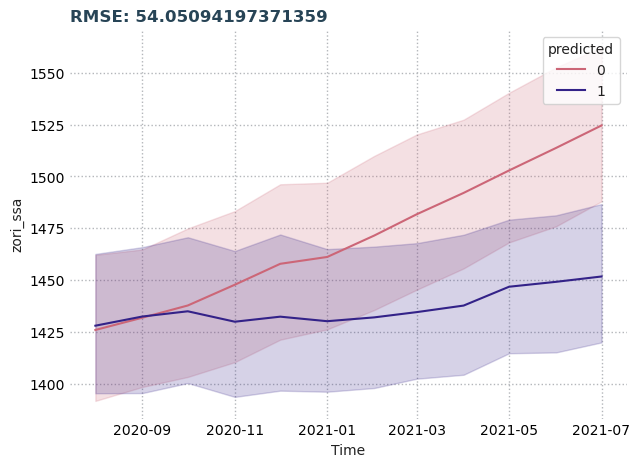

In [68]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

In [69]:
vif = vif.merge(coef_df,how='left',left_on='features',right_on='features').sort_values('VIF',
                                                                                ascending=False)

In [71]:
vif = vif.reset_index(drop=True)
vif.loc[:,'features'] = [feature.replace('_per_diff_last_year_24_month_shift', '') for feature in vif.loc[:,'features']]
vif.to_csv('acs2_after_vif.csv')

features        VIF       coefs  \
0                              zori_ssa_6_diff_lag_12  33.564887  -10.539702   
1                              zori_ssa_1_diff_lag_12  14.263150   22.739553   
2                         zori_ssa_12_diff_lag_12_per  14.067529    3.194456   
3                             zori_ssa_12_month_shift   9.505670  240.499808   
4       total_units_per_diff_last_year_24_month_shift   7.453364   -1.107606   
5   married_women_spouse_present_per_diff_last_yea...   4.810874   -0.637346   
6        single_men_per_diff_last_year_24_month_shift   3.921158   -0.017847   
7   housing_units_10_to_19_units_per_diff_last_yea...   3.607142    0.027805   
8   housing_units_10_to_19_units_rented_per_diff_l...   3.594454         NaN   
9   median_contract_rent_per_diff_last_year_24_mon...   3.569535   -0.935864   
10  median_household_income_per_diff_last_year_24_...   3.352671    0.347111   
11       median_age_per_diff_last_year_24_month_shift   3.335201    0.175324   
12     single_women_per_diff_last_year_24_month_shift   3.294886    0.105504   
13  units_paying_cash_rent_per_diff_last_year_24_m...   2.748900   -1.138040   
14  housing_units_single_family_detached_per_diff_...   2.674179    0.234499   
15  women_with_bachelors_degree_per_diff_last_year...   2.532788   -0.539859   
16   divorced_women_per_diff_last_year_24_month_shift   2.103162    0.183850   
17    male_25_to_29_per_diff_last_year_24_month_shift   2.100547         NaN   
18  men_with_bachelors_degree_per_diff_last_year_2...   2.094493         NaN   
19  female_25_to_29_per_diff_last_year_24_month_shift   2.009741    0.354757   
20  quintile_1_mean_income_per_diff_last_year_24_m...   1.975830         NaN   
21  female_30_to_34_per_diff_last_year_24_month_shift   1.941087         NaN   
22    male_30_to_34_per_diff_last_year_24_month_shift   1.936319   -0.357081   
23  top_5_percent_lower_limit_per_diff_last_year_2...   1.931693    1.518280   
24  average_household_size_owners_per_diff_last_ye...   1.856610         NaN   
25    male_35_to_39_per_diff_last_year_24_month_shift   1.856157         NaN   
26  female_55_to_59_per_diff_last_year_24_month_shift   1.799322    0.986175   
27    widowed_women_per_diff_last_year_24_month_shift   1.746951    0.480806   
28  women_with_masters_degree_per_diff_last_year_2...   1.737227         NaN   
29  average_household_size_renters_per_diff_last_y...   1.735109   -1.442032   
30    male_40_to_44_per_diff_last_year_24_month_shift   1.729358         NaN   
31  female_35_to_39_per_diff_last_year_24_month_shift   1.714415   -0.418272   
32  female_50_to_54_per_diff_last_year_24_month_shift   1.699913         NaN   
33     divorced_men_per_diff_last_year_24_month_shift   1.691981         NaN   
34  gini_coeficient_per_diff_last_year_24_month_shift   1.683514         NaN   
35  housing_units_single_family_attached_owned_per...   1.675187    0.091422   
36    male_22_to_24_per_diff_last_year_24_month_shift   1.671407   -0.216850   
37  housing_units_single_family_attached_per_diff_...   1.663311         NaN   
38  women_with_hs_diploma_per_diff_last_year_24_mo...   1.649165         NaN   
39  female_70_to_74_per_diff_last_year_24_month_shift   1.640101    0.244039   
40    male_45_to_49_per_diff_last_year_24_month_shift   1.624505   -0.217695   
41  men_with_hs_diploma_per_diff_last_year_24_mont...   1.624307    0.731555   
42    male_50_to_54_per_diff_last_year_24_month_shift   1.614966   -0.003314   
43  female_22_to_24_per_diff_last_year_24_month_shift   1.601764         NaN   
44  women_with_one_year_or_more_college_per_diff_l...   1.597163    0.914530   
45  female_45_to_49_per_diff_last_year_24_month_shift   1.584642         NaN   
46    male_55_to_59_per_diff_last_year_24_month_shift   1.577869    0.999316   
47  men_with_masters_degree_per_diff_last_year_24_...   1.566919   -0.448927   
48  housing_units_single_family_detached_rented_pe...   1.561099    1.870715   
49  men_with_one_year_or_more_college_per_dif

In [78]:
vif.to_csv('acs2_after_vif.csv')

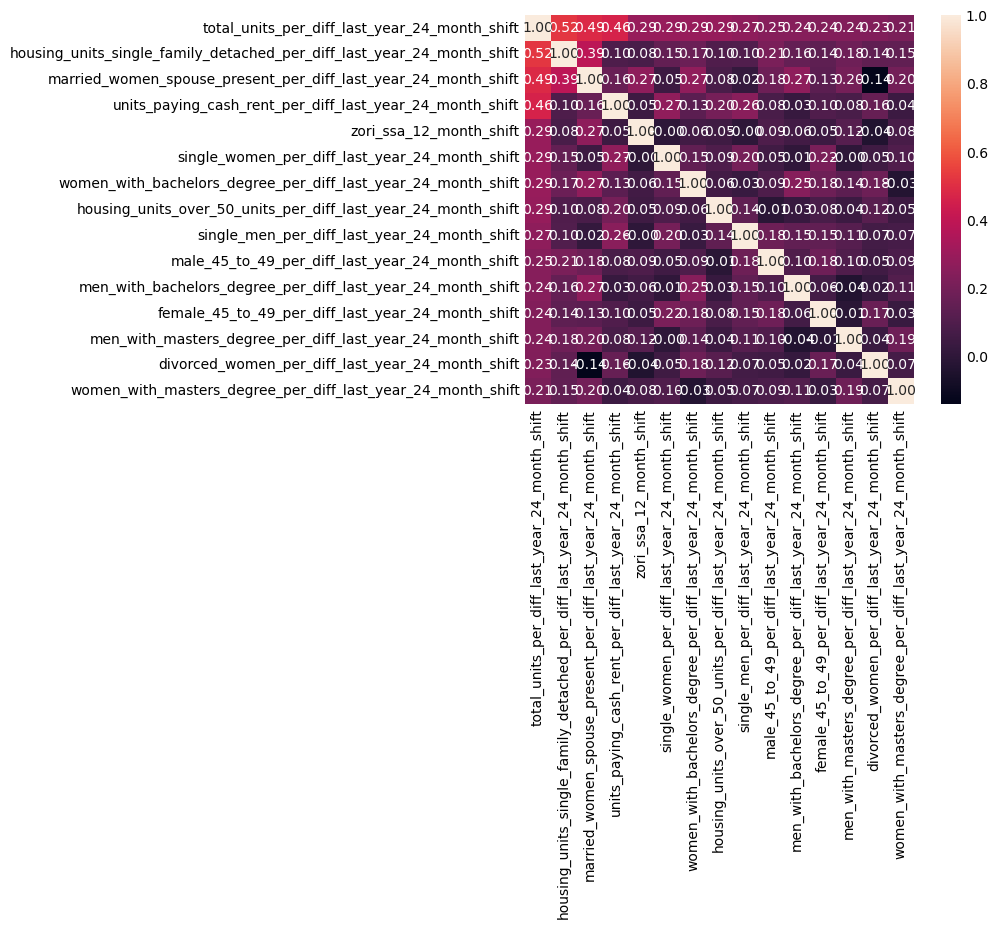

In [23]:
corr_feat_pick = 'total_units_per_diff_last_year_24_month_shift'

k = 15 #number of variables for heatmap
cols = X_w_cols.corr().nlargest(k, corr_feat_pick)[corr_feat_pick].index
cm = np.corrcoef(X_w_cols[cols].values.T)
# sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

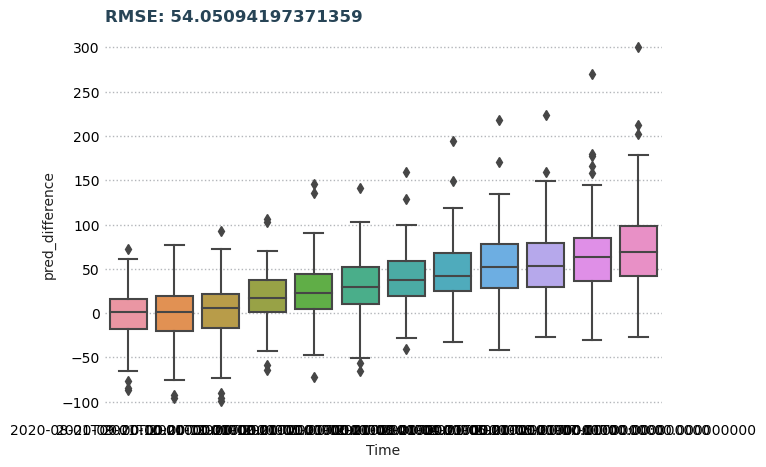

In [24]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

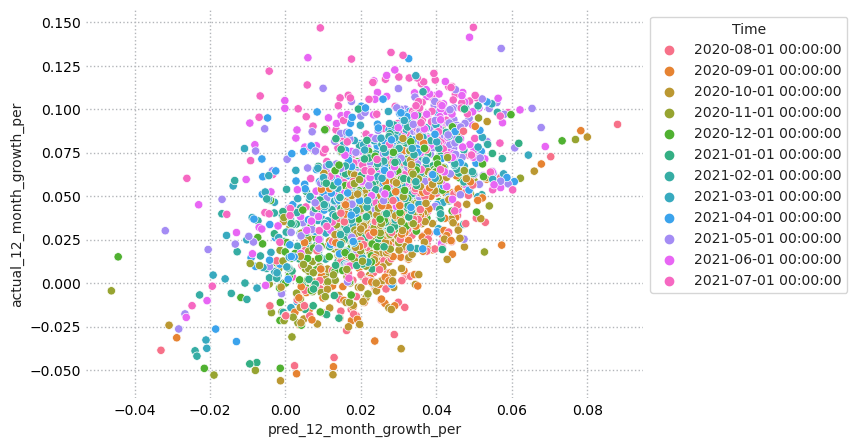

In [25]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']
# test['month'] = test['Time'].dt.month

g = sns.scatterplot(data = test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
plt.show()

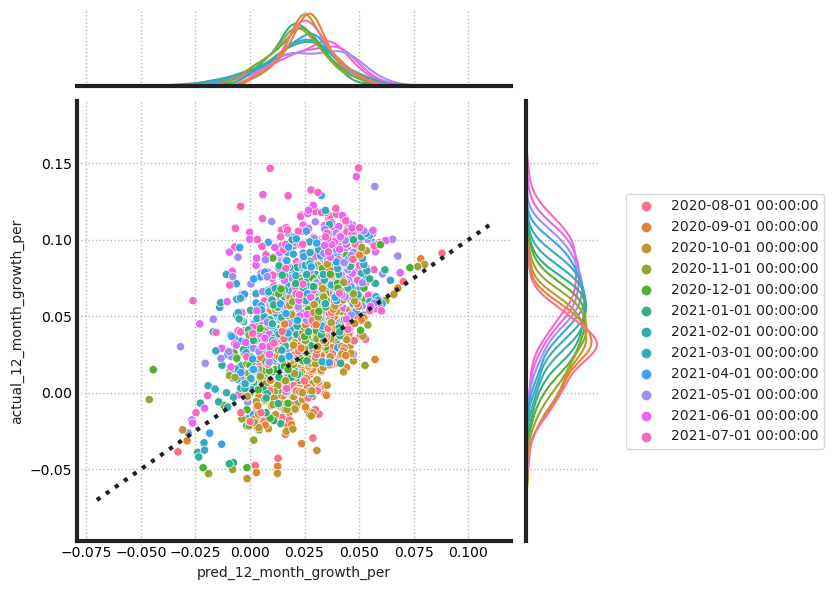

In [26]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

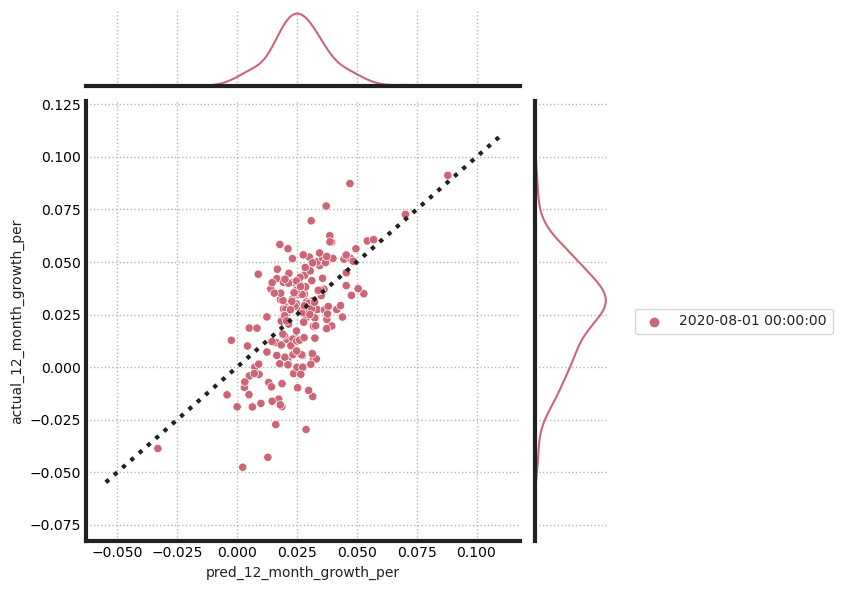

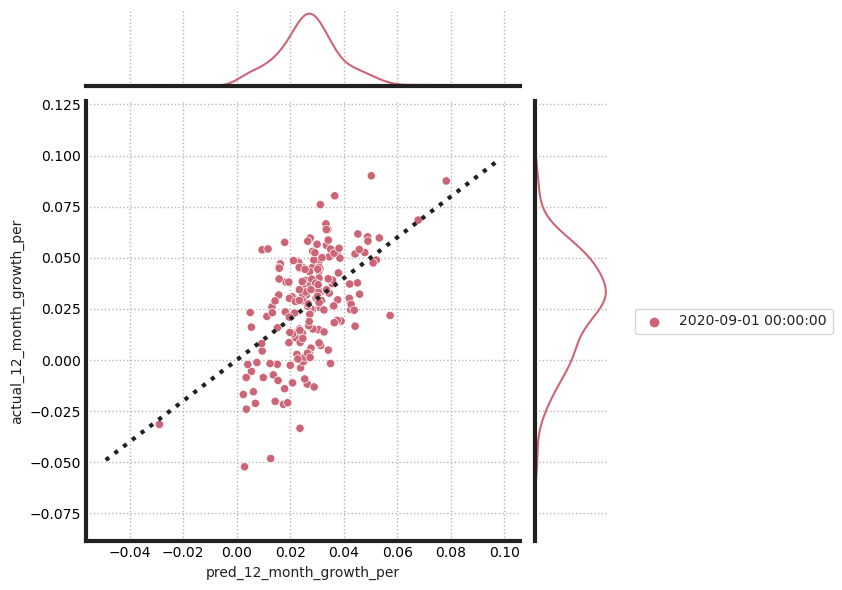

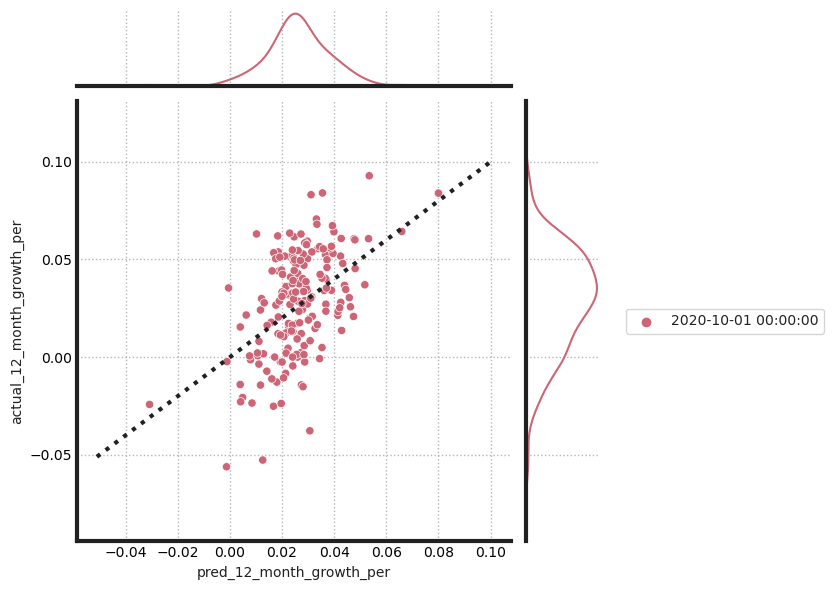

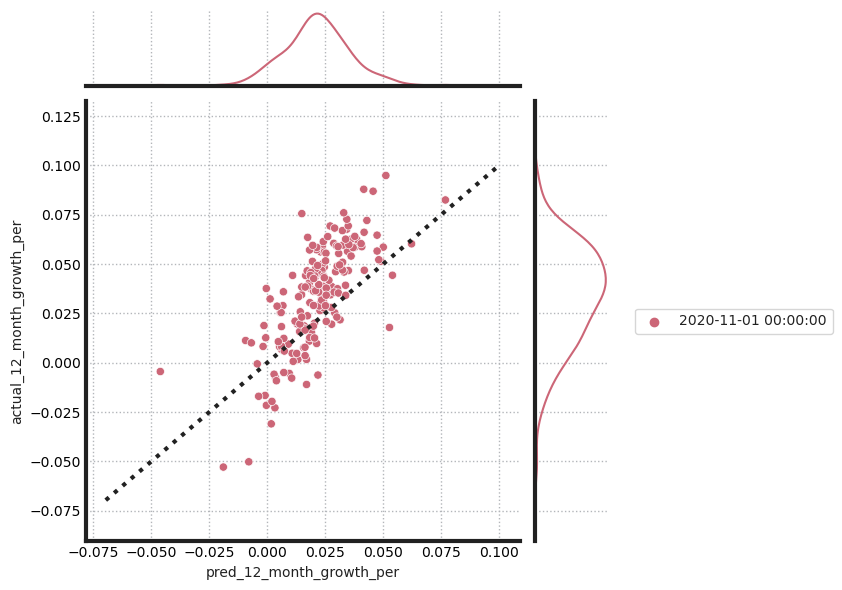

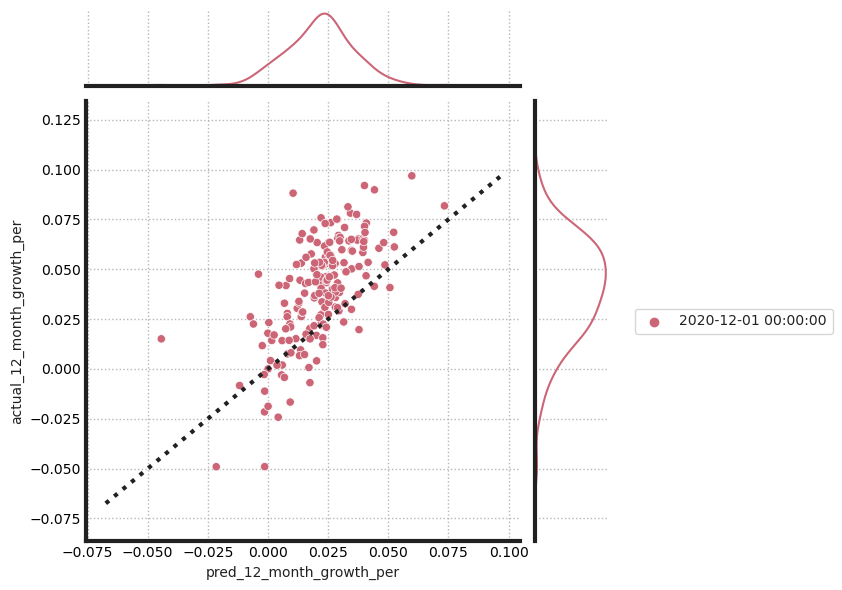

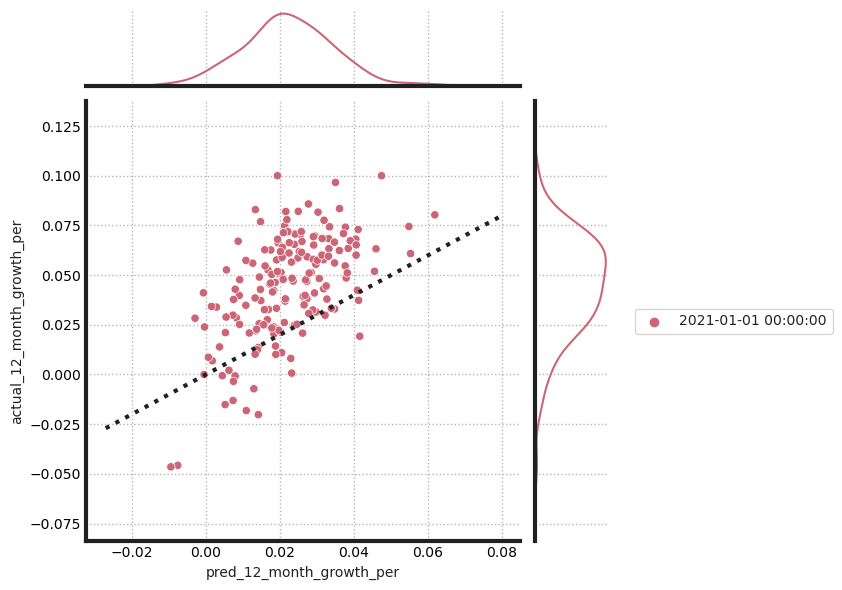

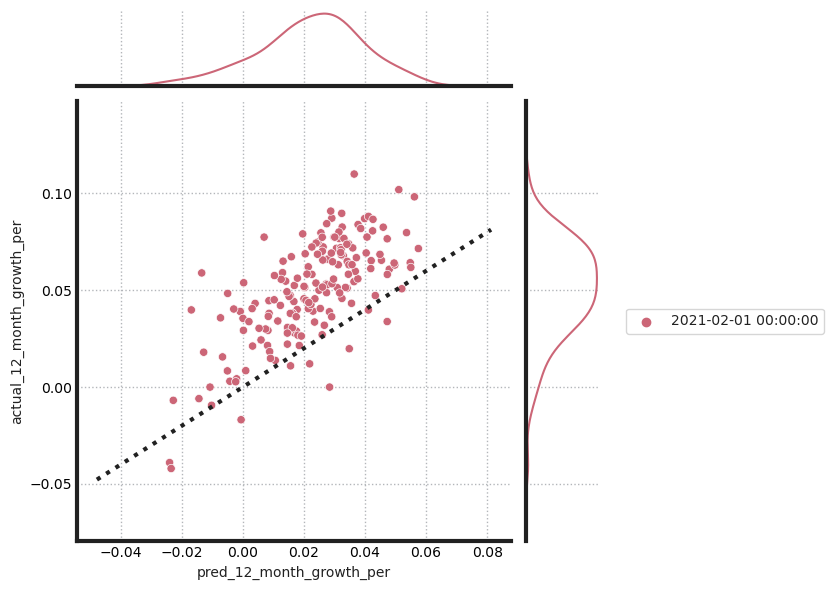

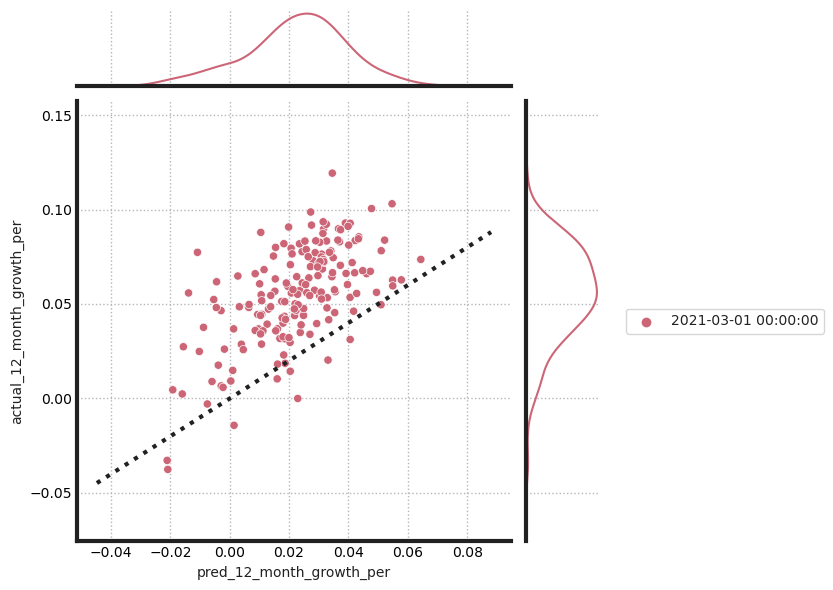

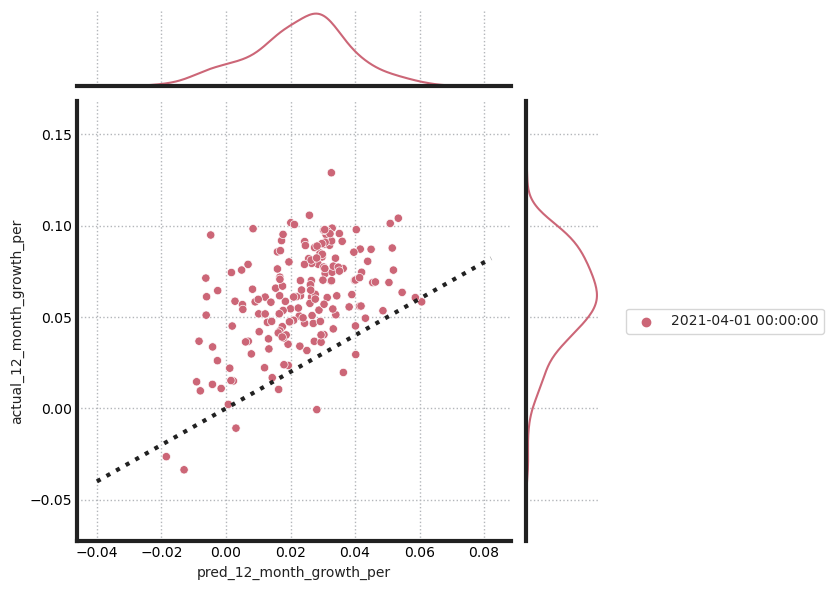

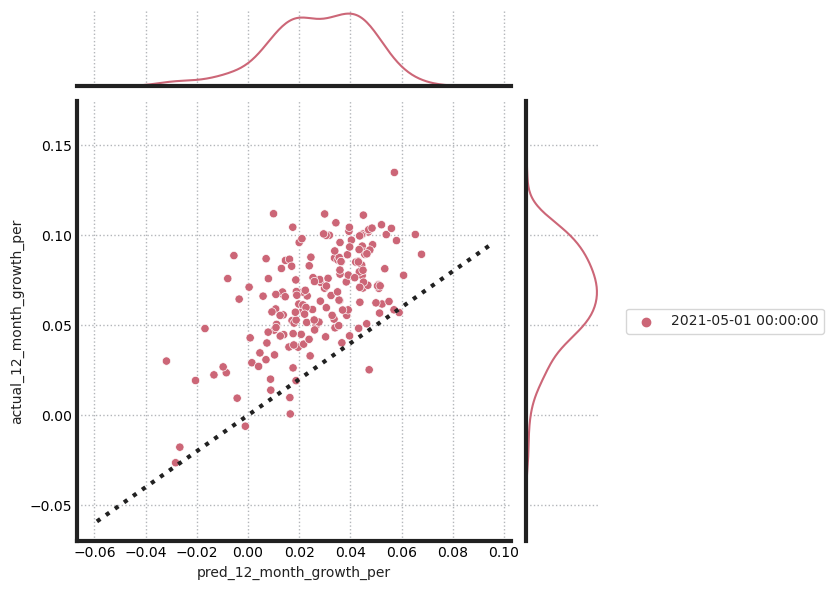

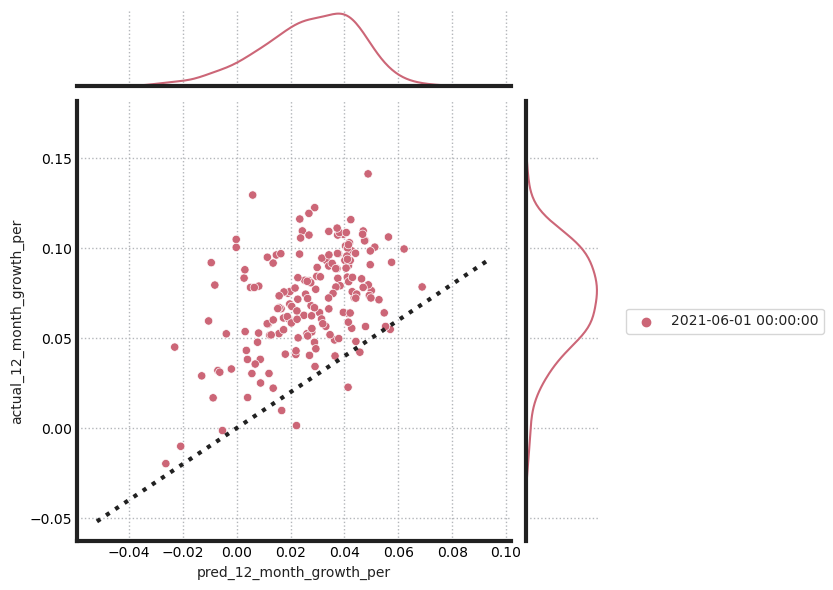

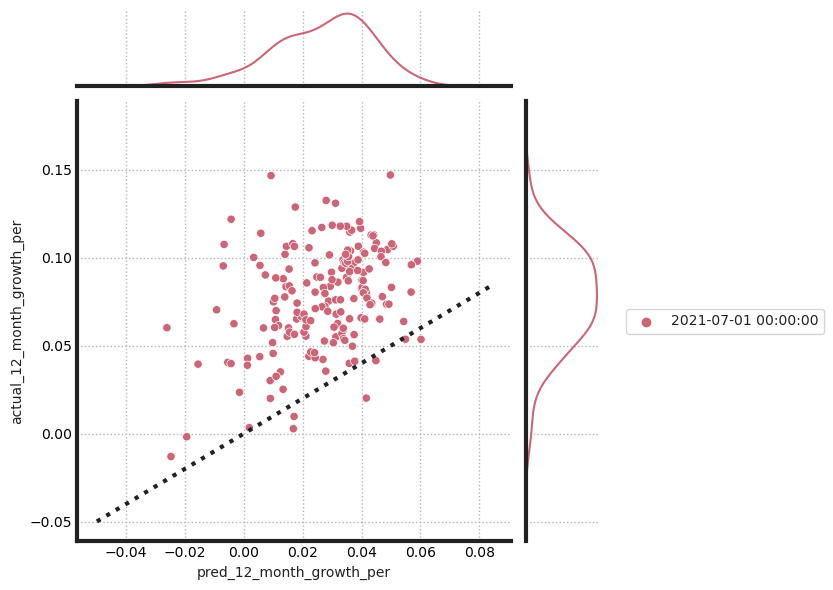

In [27]:

for month in test.Time.unique():
    g = sns.JointGrid(data=test[test['Time']==month], x = 'pred_12_month_growth_per', 
                    y = 'actual_12_month_growth_per', hue='Time',
                     )


    g.plot_joint(sns.scatterplot,)
    g.plot_marginals(sns.kdeplot,legend=False)

    g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')
    g.fig.suptitle("")
    plt.show()

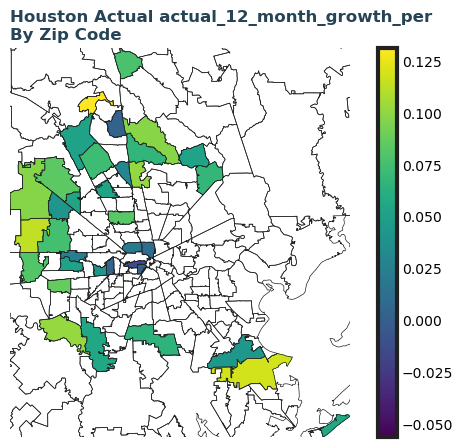

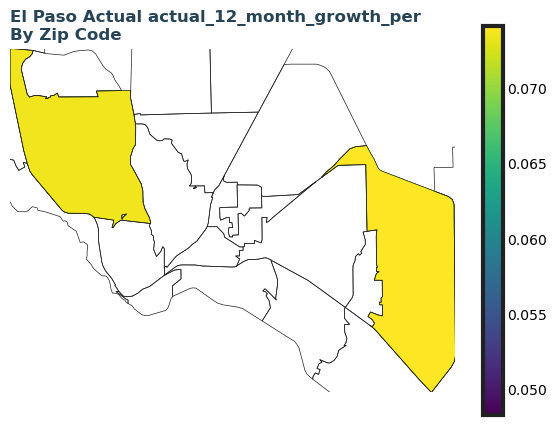

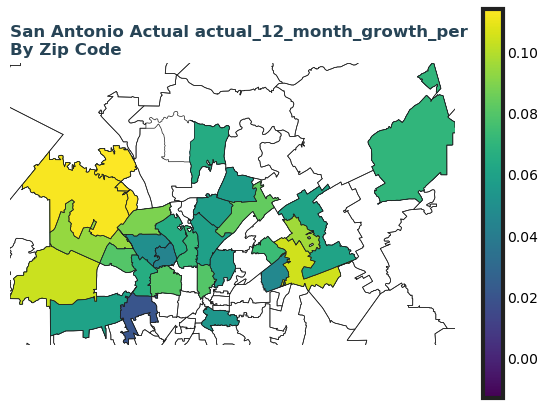

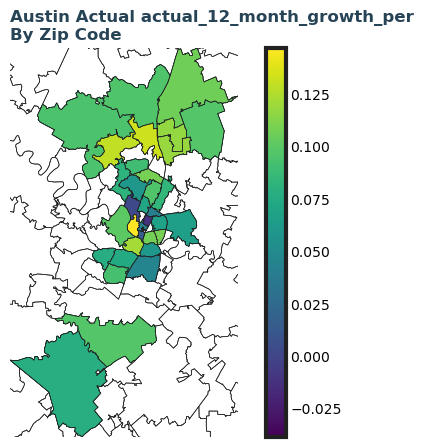

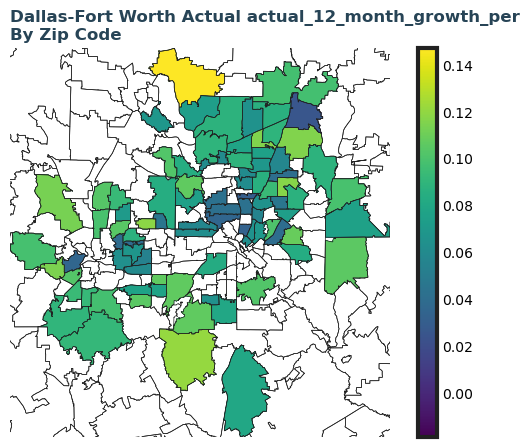

In [28]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["actual_12_month_growth_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual actual_12_month_growth_per\nBy Zip Code')
    plt.show()

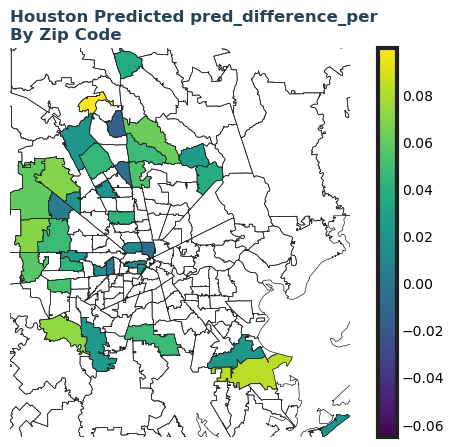

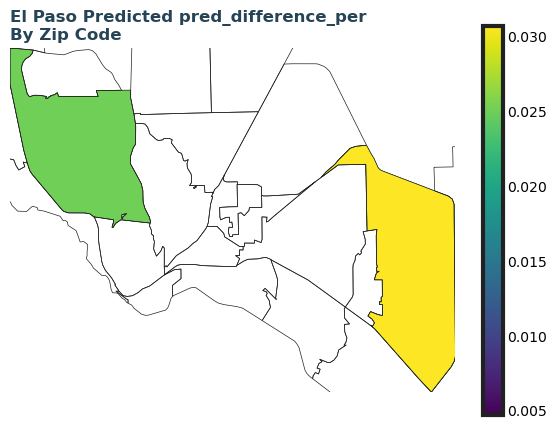

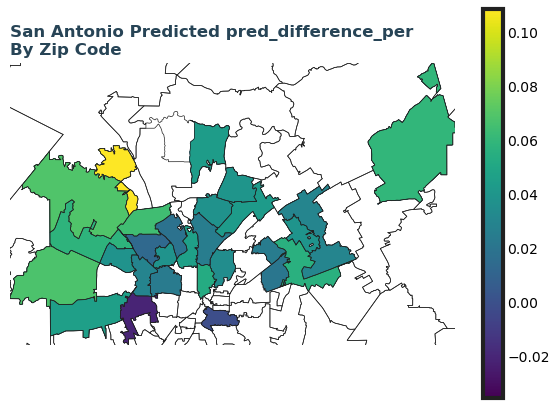

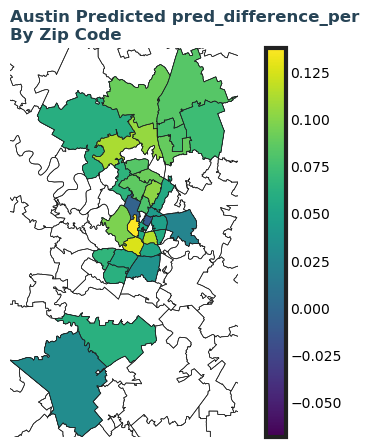

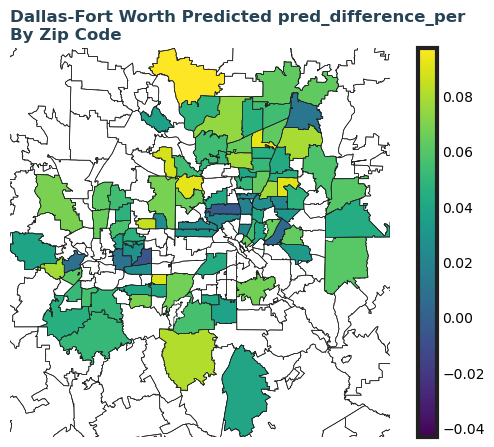

In [29]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted pred_difference_per\nBy Zip Code')
    plt.show()

In [30]:
five_per_zips = list(test[test['pred_12_month_growth_per']>.05].zip_code.unique())
naive_five_per_zips = list(test[test['zori_ssa_12_diff_lag_12_per']>.05].zip_code.unique())


In [31]:
test.loc[:,'invest_rec_5_per'] = 0
test.loc[test['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
test.loc[test['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
test.loc[(test['zip_code'].isin(naive_five_per_zips) &
          test['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2


In [32]:
test.loc[test['invest_rec_5_per']==3,'zip_code'].unique()

array([79936, 79912, 75243, 78240, 78228, 78250, 75149, 78216, 78109,
       78229, 76227, 77073, 77301, 78239, 78023, 75041, 78148])

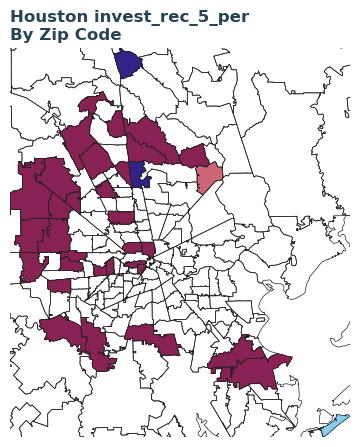

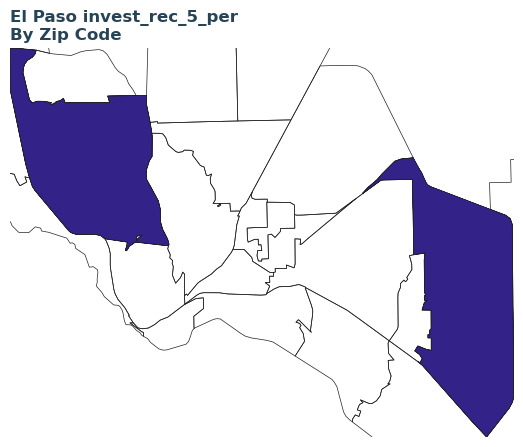

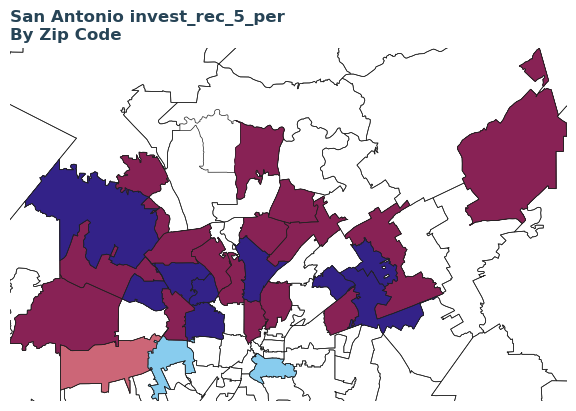

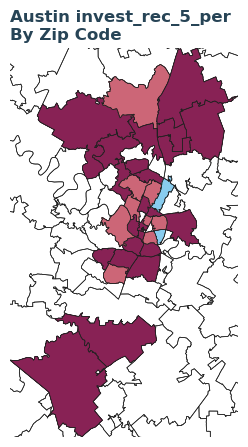

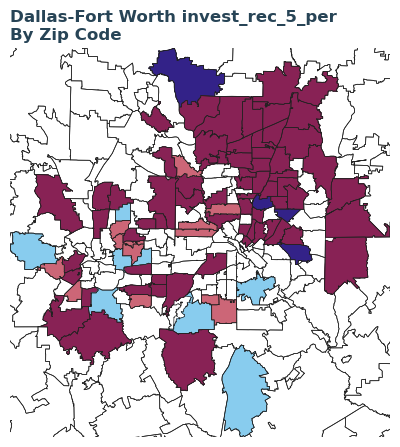

In [33]:
color = ['#882255','#cc6677','#88ccee','#332288']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,color))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' invest_rec_5_per\nBy Zip Code')
    plt.show()

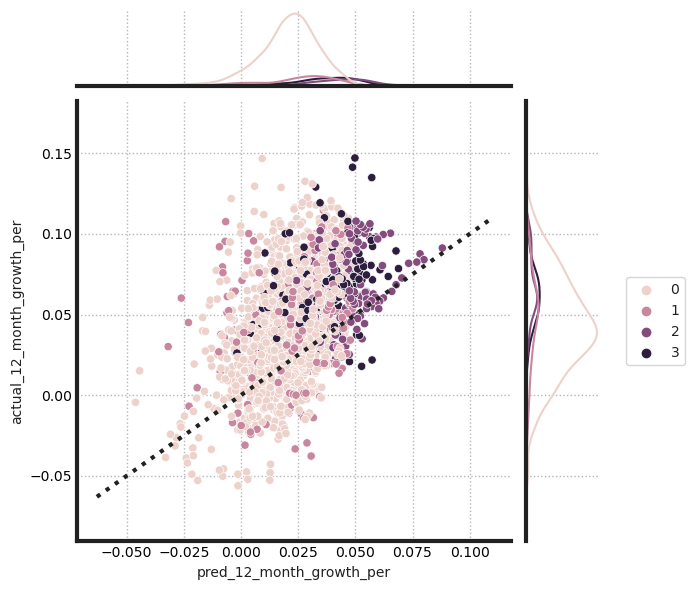

In [34]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='invest_rec_5_per',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

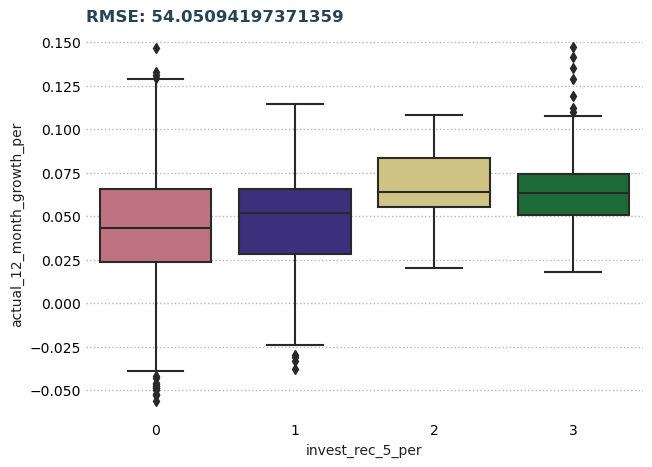

In [35]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'invest_rec_5_per',y = 'actual_12_month_growth_per', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [36]:
# # zri_shift 6-12 months
# zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
#     6:['zori_ssa'],
#     7:['zori_ssa'],
#     12:['zori_ssa'],
#     18:['zori_ssa']
# },
#                                           return_cols = True
#                                          )
# zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# # Adding the shift values
# zri_shift.loc[:,'zori_ssa_1_diff__lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_7_month_shift'])
# zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_12_month_shift'])
# zri_shift.loc[:,'zori_ssa_12_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_18_month_shift'])
# zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']]


In [37]:
# X_vals = ['zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']
# y_val = 'zori_ssa'

# # for metro in metros:
# train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
# test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
# cat_feats_=[]

# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train[X_vals]
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats_)], remainder='passthrough')
# X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = train[y_val]

# # Grid Search set up.

# alphas = [0.3, 0.6, 1]
# tuned_parameters = [{'alpha': alphas}]
# print(f'Performing Grid Search with alphas of: {alphas}')
# clf = GridSearchCV(lasso, tuned_parameters, 
#                     cv=3,n_jobs = -1,
#                   scoring = 'neg_root_mean_squared_error')
# # best_alpha = clf.best_params_['alpha']
# clf.fit(X, y)

# X_test = test[X_vals]
# X_test = transformer.transform(X_test)
# X_test = scaler.transform(X_test)
# y_test = test[y_val]
# y_predicted = clf.predict(X_test)
# test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

# rms = mean_squared_error(y_test, y_predicted, squared=False)
# test.loc[:,'pred'] = y_predicted

In [38]:
# test['pred_6_month_growth'] = test['pred'] - test['zori_ssa_6_month_shift']
# test['actual_6_month_growth'] = test['zori_ssa'] - test['zori_ssa_6_month_shift']

In [39]:
# test['pred_6_month_growth_per'] = test['pred_6_month_growth']/test['zori_ssa_6_month_shift']
# test['actual_6_month_growth_per'] = test['actual_6_month_growth']/test['zori_ssa_6_month_shift']
# test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_6_month_shift']
# test['month'] = test['Time'].dt.month


In [40]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
# plt.show()

In [41]:
# g = sns.JointGrid(data=test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time',
#                  )


# g.plot_joint(sns.scatterplot,)
# g.plot_marginals(sns.kdeplot,legend=False)

# g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
# x0, x1 = g.ax_joint.get_xlim()
# y0, y1 = g.ax_joint.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
# g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

# plt.show()

In [42]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))

# plt.show()

In [43]:
# sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [44]:
# sns.scatterplot(data = test[test['month']==7], x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [45]:
# graph_df1 = test[['Time',y_val]]
# graph_df1.loc[:,'predicted'] = 0 
# graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
# graph_df2.loc[:,'predicted'] = 1
# graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

# g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
# plt.title(f'RMSE: {rms}')
# plt.show()

In [46]:
# sns.lineplot(data = zri,  x = 'Time',y = y_val)
# plt.show()

In [47]:
# graph_df = test
# graph_df['month'] = graph_df['Time'].dt.month
# g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
#                 )
# plt.title(f'RMSE: {rms}')
# plt.show()

In [48]:
# coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
# coef_df = coef_df[coef_df['coefs']!=0]
# coef_df['coefs_abs'] = abs(coef_df['coefs'])
# coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
# coef_df

In [49]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["pred_difference"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro+' Predicted Difference\nBy Zip Code')
#     plt.show()

In [50]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["zori_ssa"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro +' Actual ZRI\nBy Zip Code')
#     plt.show()